In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('planets').getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('planets') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [2]:
import matplotlib.pyplot as plt
import seaborn
import scipy.io
import numpy as np
import seaborn
import sklearn.decomposition
import scipy.linalg
import math
import pandas
%matplotlib inline

from operator import add
import pyspark.sql.functions
import pyspark.mllib.clustering
import pyspark.mllib.classification
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.linalg import  SparseVector, DenseMatrix, DenseVector

import re
import functools

# 2. Planet hunting

In [3]:
lc = spark.read.json('/project/cmsc25025/light_curve/lightcurves-sample.json')

In [4]:
lc.show(12)

+--------------------+-----+--------------------+--------------------+
|                flux|label|                name|                time|
+--------------------+-----+--------------------+--------------------+
|[194602.078125, 1...| conf|kplr002581316-201...|[1274.14019845467...|
|[6818722.5, 68190...| conf|kplr003632418-201...|[1274.14035648731...|
|[48374.2421875, 4...| conf|kplr003733628-201...|[1274.14035006258...|
|[86651.015625, 86...| conf|kplr004150804-201...|[1274.14022049512...|
|[12159.1142578125...|   eb|kplr001026032-201...|[1274.14036272274...|
|[96343.7734375, 9...|   eb|kplr001026957-201...|[1274.14035174874...|
|[208676.5625, 208...|   eb|kplr001161345-201...|[1274.14035372128...|
|[3648.109375, 364...|   eb|kplr001432214-201...|[1274.14031962276...|
|[7149.537109375, ...|   fp|kplr000892772-201...|[1274.14036161633...|
|[1170351.625, 117...|   fp|kplr001025986-201...|[1274.14035989129...|
|[36673.83984375, ...|   fp|kplr001027438-201...|[1274.14034383971...|
|[2524

## Part a)

In [5]:
flux = np.array(lc.take(1)[0]['flux'], dtype='float64')
time = np.array(lc.take(1)[0]['time'], dtype='float64')

We will be using the fisrt light curve as out working data, our examined h valuess are:

In [6]:
hVals = np.exp(np.arange(0, 10, .1))
hVals

array([  1.00000000e+00,   1.10517092e+00,   1.22140276e+00,
         1.34985881e+00,   1.49182470e+00,   1.64872127e+00,
         1.82211880e+00,   2.01375271e+00,   2.22554093e+00,
         2.45960311e+00,   2.71828183e+00,   3.00416602e+00,
         3.32011692e+00,   3.66929667e+00,   4.05519997e+00,
         4.48168907e+00,   4.95303242e+00,   5.47394739e+00,
         6.04964746e+00,   6.68589444e+00,   7.38905610e+00,
         8.16616991e+00,   9.02501350e+00,   9.97418245e+00,
         1.10231764e+01,   1.21824940e+01,   1.34637380e+01,
         1.48797317e+01,   1.64446468e+01,   1.81741454e+01,
         2.00855369e+01,   2.21979513e+01,   2.45325302e+01,
         2.71126389e+01,   2.99641000e+01,   3.31154520e+01,
         3.65982344e+01,   4.04473044e+01,   4.47011845e+01,
         4.94024491e+01,   5.45981500e+01,   6.03402876e+01,
         6.66863310e+01,   7.36997937e+01,   8.14508687e+01,
         9.00171313e+01,   9.94843156e+01,   1.09947172e+02,
         1.21510418e+02,

In [7]:
#making these global since the docs say they are consistent across all measurements
gap = 0.0204
N = len(flux)
sz = (N-1)/2
Xdeltas = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)

notNanIndices = [i for i, v in enumerate(flux) if not math.isnan(v)]
nanIndices = [i for i, v in enumerate(flux) if math.isnan(v)]

def kernel_epa(u):
    w = (abs(u) <= 1) * (1 - u*u)
    return w

def kernel_tri(u):
    w = (abs(u) <= 1) * (1 - abs(u*u*u))
    return w

def kernel_gaussian(u):
    w = np.exp(- np.square(u) / 2) / np.sqrt(np.pi*2)
    return w

def kernel_boxcar(u):
    w = (abs(u) <= 1)
    return w

Note that instead of setting the missing vlaues to 0, we are setting them to the mean

In [150]:
def getEstimate(flux, h, dropNan = False, kernel = kernel_gaussian):
    if dropNan:
        flux = flux[notNanIndices]
        w = kernel(Xdeltas/h)[notNanIndices]
        m = 0
    else:
        w = kernel(Xdeltas/h)
        m = flux[notNanIndices].mean()
    
    w = w[w > 0]
    const = np.convolve(w, np.ones(len(flux), dtype=np.float64), 'same')
    yhat = np.convolve(w, np.nan_to_num(flux - m) , 'same') / const
    return yhat + m

In [151]:
def rHat(flux, h, kernel = kernel_gaussian):
    w = kernel(Xdeltas / h)
    Lii = 1 / np.convolve(w[w > 0], np.ones(N, dtype=np.float64), 'same')
    yHat = getEstimate(flux, h, True, kernel = kernel)
    errs = ((flux[notNanIndices] - yHat) / (1 - Lii[notNanIndices]))
    return np.mean(np.nan_to_num(np.square(errs)))

In [152]:
def findH(flux, kernel = kernel_gaussian):
    rVals = []
    fluxMean = np.mean(flux)
    for h in hVals:
        rVals.append(rHat(flux, h, kernel = kernel))
    return hVals[np.argmin(rVals)]

In [153]:
minh = findH(flux)
minh

3.6692966676192444

In [154]:
rHat(flux, minh)

569229.00838270283

For the first curve we can see that the optimal h value is 1 with a risk of $569229.00838270283$ the gaussian kernel, this correspounds to a some what sharp spike of a kernel. Note that for finding $h$ missing values were dropped thus the distnace between nodes with missing values inbetween was reduced

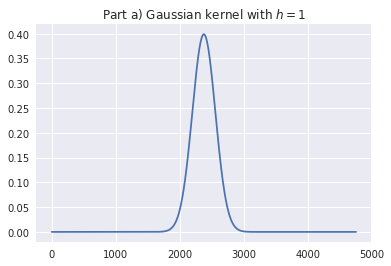

In [155]:
plt.plot(kernel_gaussian(Xdeltas/minh))
plt.title("Part a) Gaussian kernel with $h =1$")
plt.show()

We can also plot the regression estimate

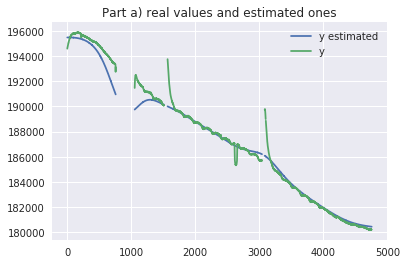

In [156]:
yHat = getEstimate(flux, minh)
yHat[nanIndices] = float('nan')
plt.plot(yHat, label = 'y estimated')
plt.plot(flux, label = 'y')
plt.title("Part a) real values and estimated ones")
plt.legend()
plt.show()

## Part b)

In [157]:
ri = flux - yHat

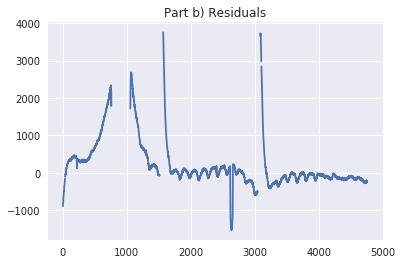

In [158]:
plt.plot(ri)
plt.title("Part b) Residuals")
plt.show()

## Part c)

In [159]:
def mad(r):
    med = np.median(r)
    return np.median(np.abs(r - med))

In [160]:
ri_norm = (ri - ri[notNanIndices].mean()) / (1.4826 * mad(ri[notNanIndices]))

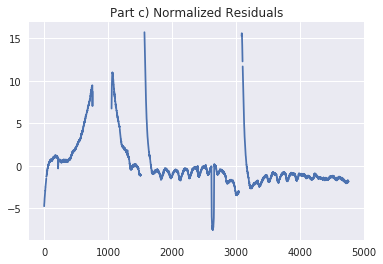

In [161]:
plt.plot(ri_norm)
plt.title("Part c) Normalized Residuals")
plt.show()

## Part d)

In [162]:
beta = np.sqrt(2 * np.log(len(flux)))

In [163]:
riTilde = np.array([r if r < - beta else 0 for r in ri_norm])

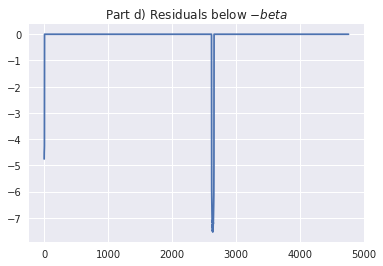

In [164]:
plt.plot(riTilde)
plt.title("Part d) Residuals below $- beta$")
plt.show()

# Complete runs

We can collect the procedure from above into the below function to make each star's run easy

In [165]:
def runCurve(row):
    flux = np.array(row['flux'], dtype='float64')
    time = np.array(row['time'], dtype='float64')
    fig, axes = plt.subplots(figsize = (20, 10), ncols=2, nrows=2)
    minh = findH(flux)
    rHat(flux, minh)
    yHat = getEstimate(flux, minh)
    yHat[nanIndices] = float('nan')
    axes[0,0].plot(time, yHat, label = 'y estimated')
    axes[0,0].plot(time, flux, label = 'y')
    axes[0,0].set_title("Part a) real values and estimated ones")
    axes[0,0].legend()
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Flux')

    ri = flux - yHat
    axes[0,1].plot(time, ri)
    axes[0,1].set_title("Part b) Residuals")
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Estimate Residual')
    
    ri_norm = (ri - ri[notNanIndices].mean()) / (1.4826 * mad(ri[notNanIndices]))
    axes[1,0].plot(time, ri_norm)
    axes[1,0].set_title("Part c) Normalized Residuals")
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Estimate Normalized Residual')
    beta = np.sqrt(2 * np.log(len(flux)))
    riTilde = np.array([r if r < - beta else 0 for r in ri_norm])
    axes[1,1].plot(time, riTilde)
    axes[1,1].set_title("Part d) Residuals below $- beta$\t$-beta = {:.2f}$".format(beta))
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Estimate Normalized Residual below $-beta$')
    fig.suptitle('{} Flux levels\nA {} class start'.format(row['name'], row['label']))
    plt.show()

In [166]:
rows = lc.collect()

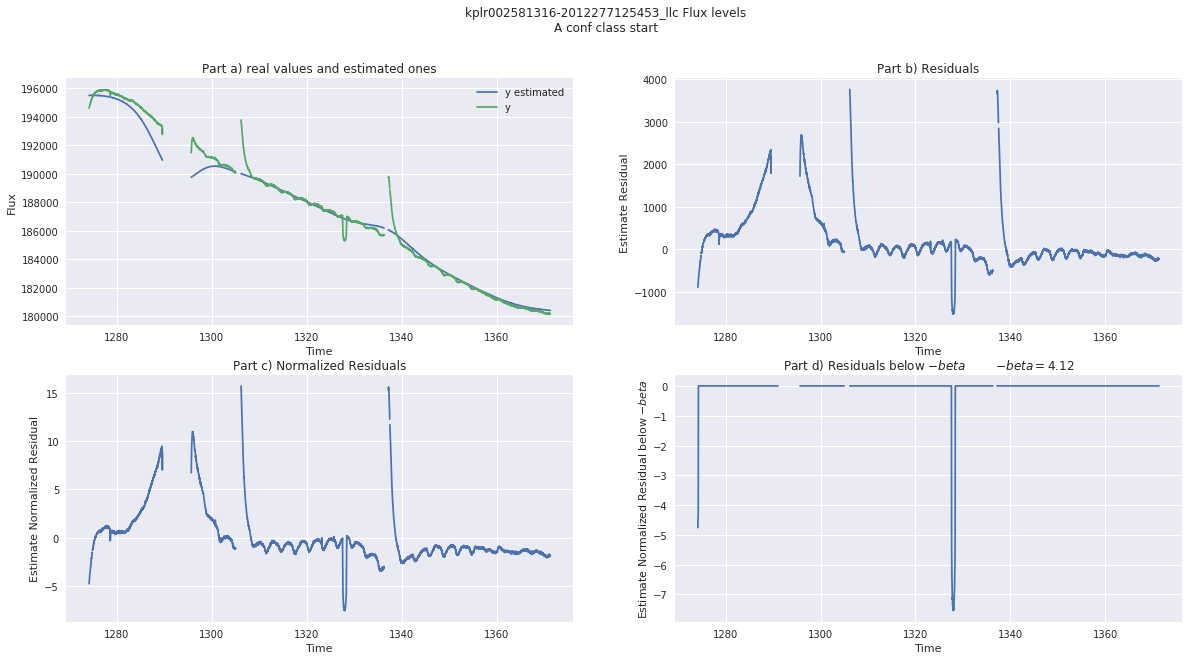

In [167]:
runCurve(rows[0])

We can see from the residuals plot two major dips in flux these are not aligned with the regular pattern and thus suggest a planet

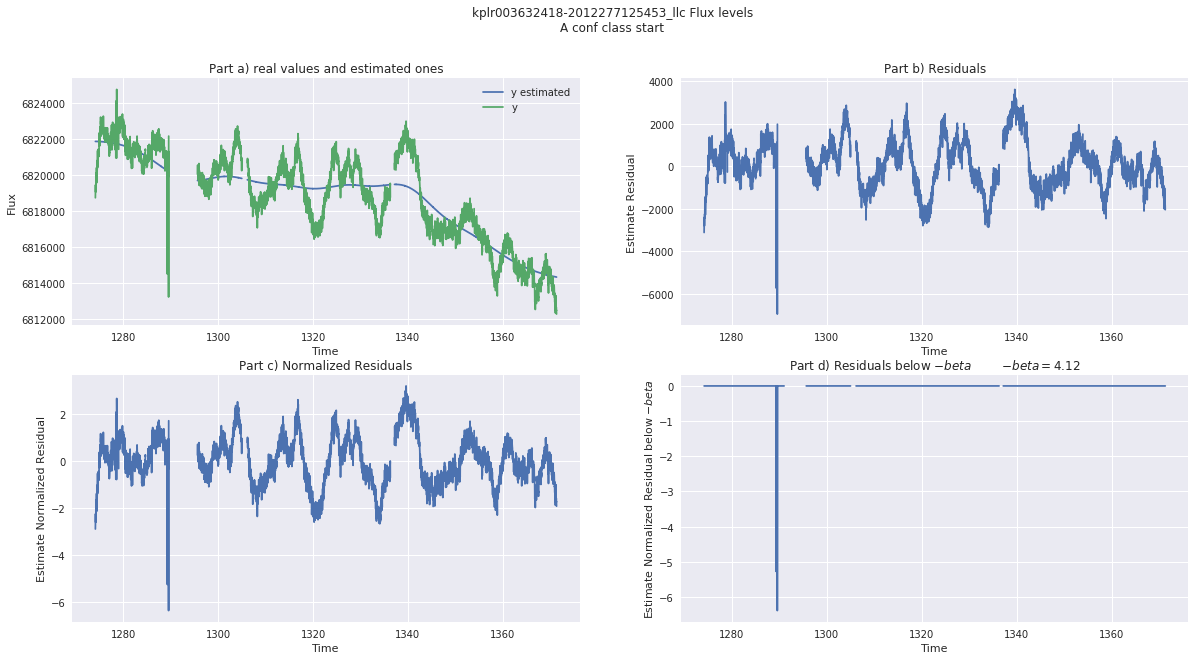

In [168]:
runCurve(rows[1])

We can see from the residuals plot one major dip in flux that is not aligned with the regular pattern and thus suggest a planet

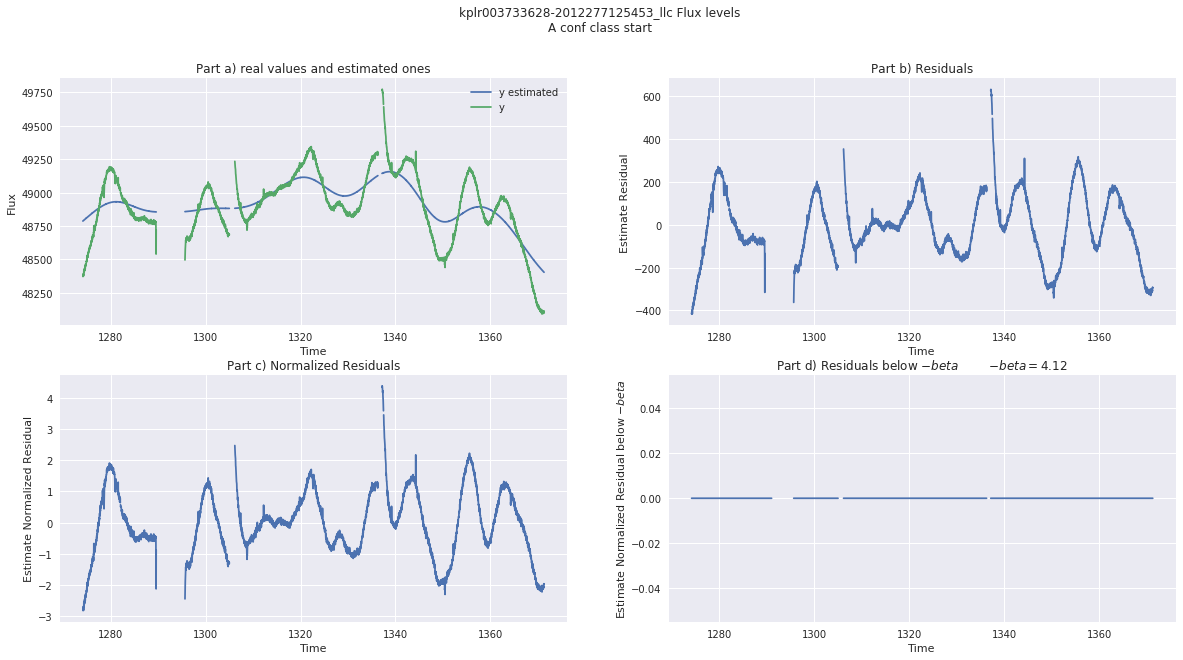

In [169]:
runCurve(rows[2])

We can see from the residuals plot no major dips in flux, the planet is classed as a `conf` though. There are a couple dips visible in the residuals so perhaps a slighly higher threshold would classify this as a planet. Also some of the dipbs being near missing values does not help.

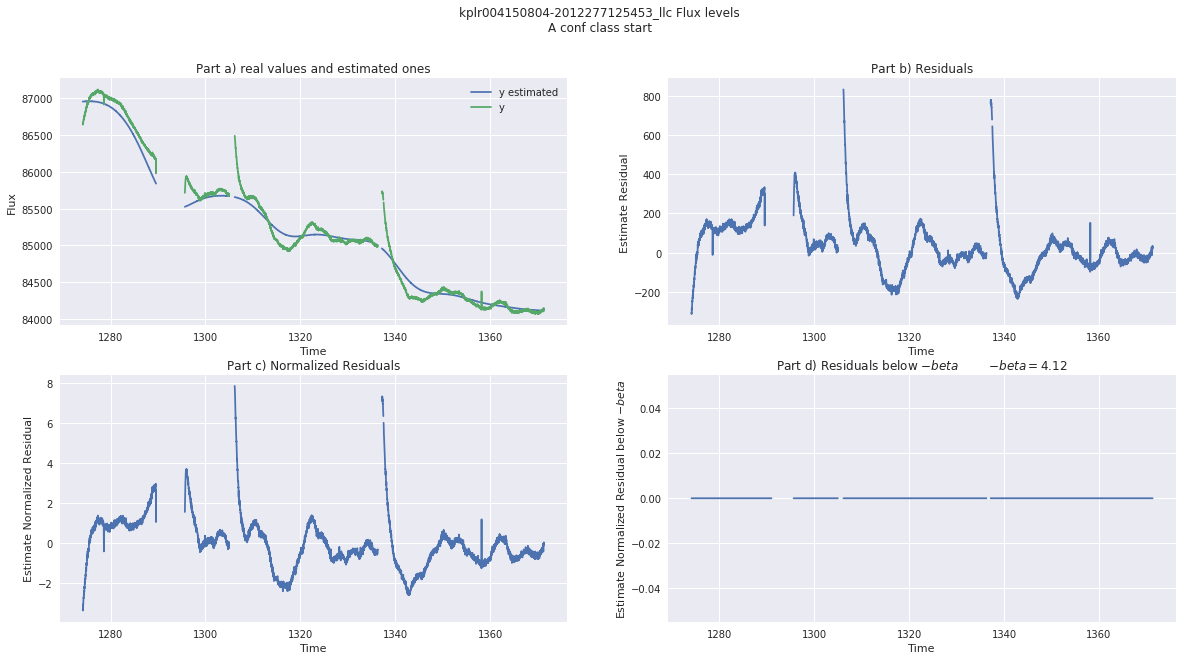

In [170]:
runCurve(rows[3])

Again, we can see from the residuals plot no major dips in flux, the planet is classed as a `conf` though. There are a no real dips visible in the residuals though so $beta$ would have to be very high to catch it.

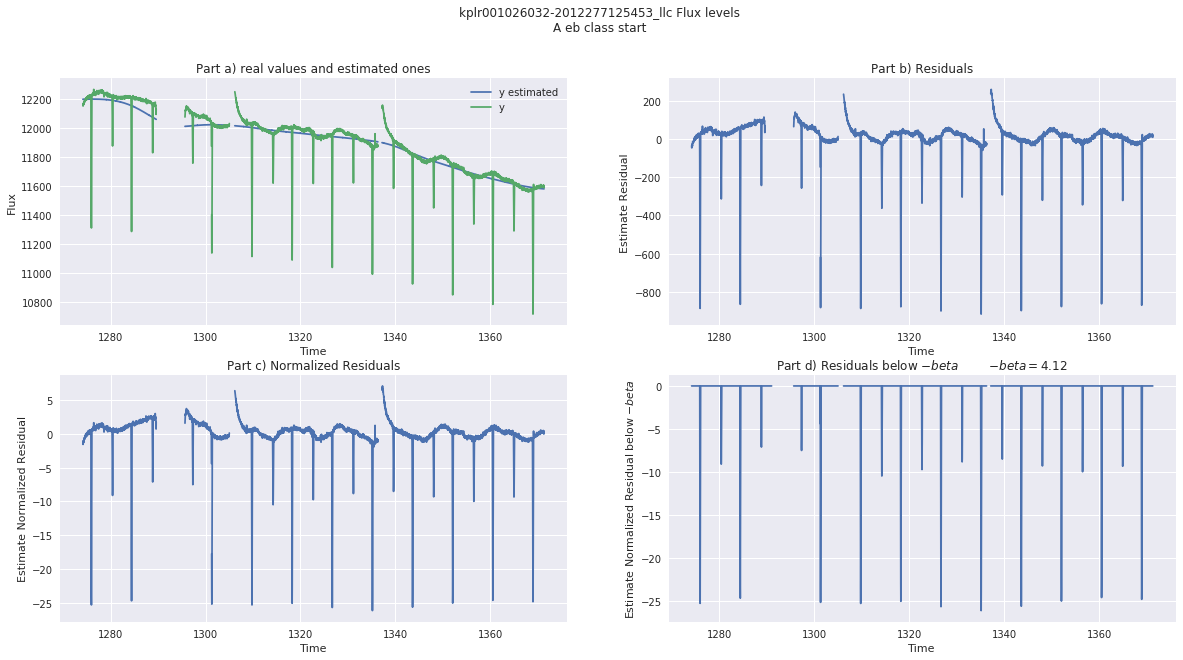

In [172]:
runCurve(rows[4])

The pattern of eclipses and occultations is very clear this is definitely and `eb` 

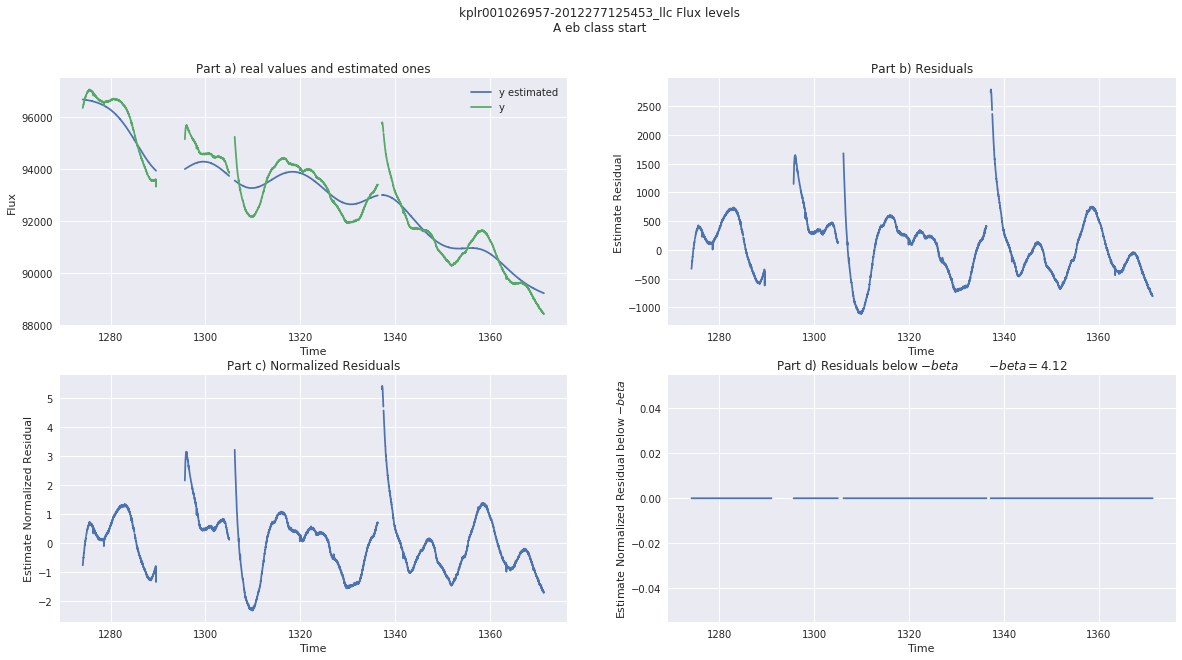

In [173]:
runCurve(rows[5])

There is no pattern of eclipses and occultations in the residuals it is not clear this is an `eb` 

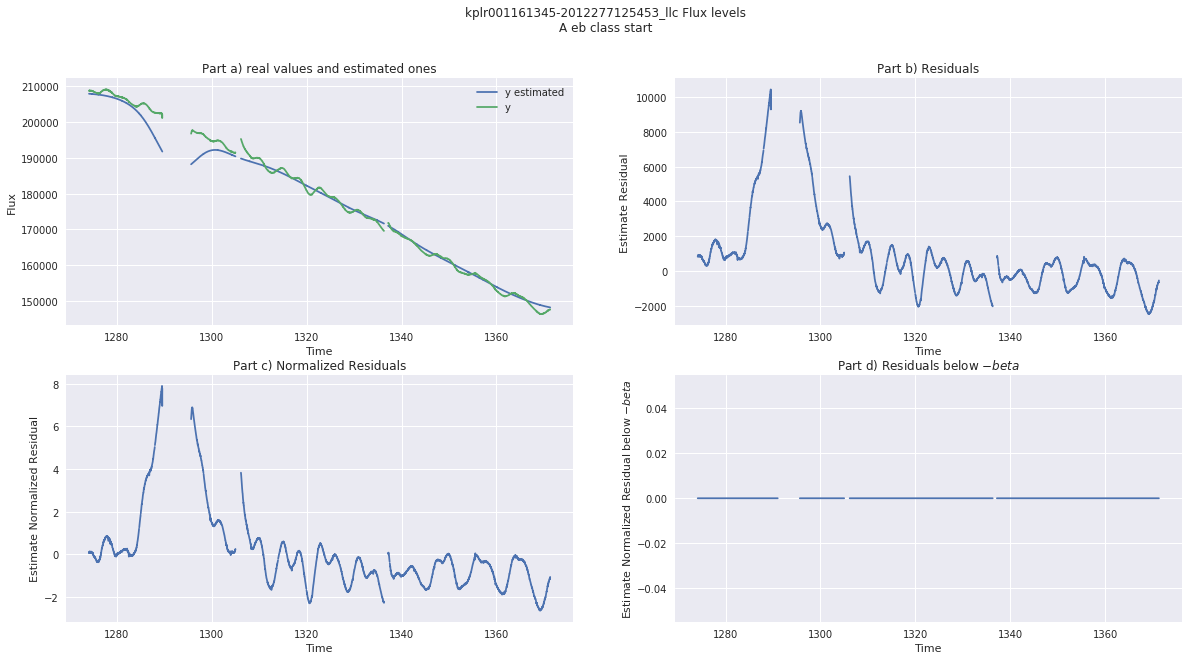

In [113]:
runCurve(rows[6])

There is no pattern of eclipses and occultations in the residuals it is not clear this is an `eb` 

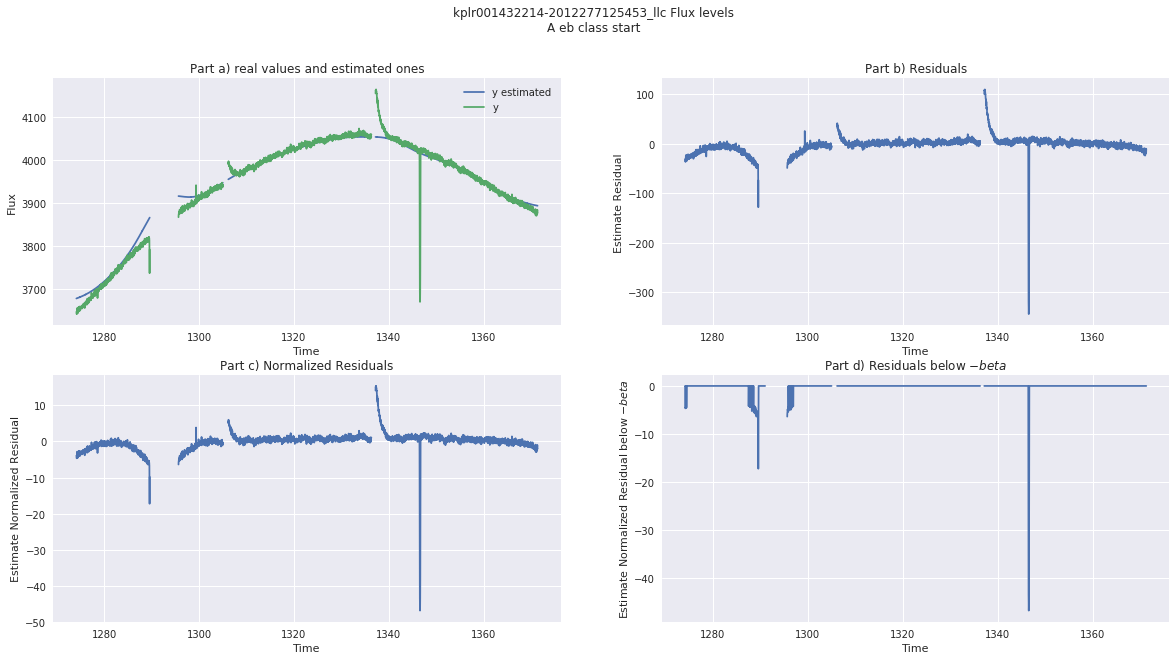

In [114]:
runCurve(rows[7])

We can see from the residuals plot two major dips in flux that are not aligned with the regular pattern and thus suggest a planet

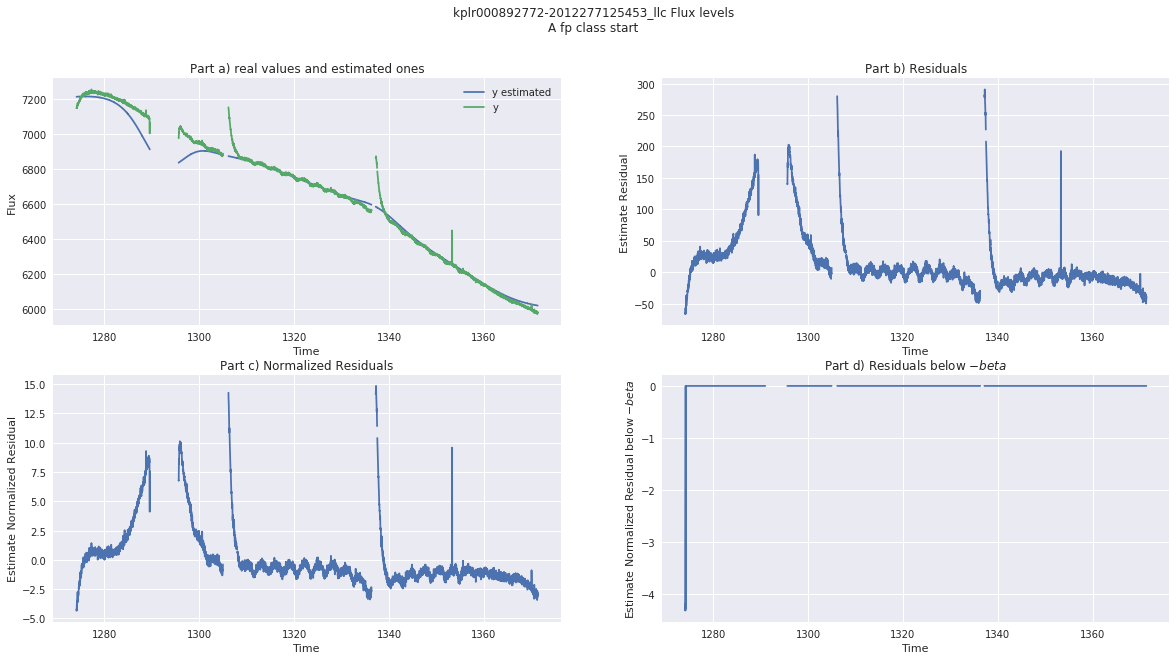

In [115]:
runCurve(rows[8])

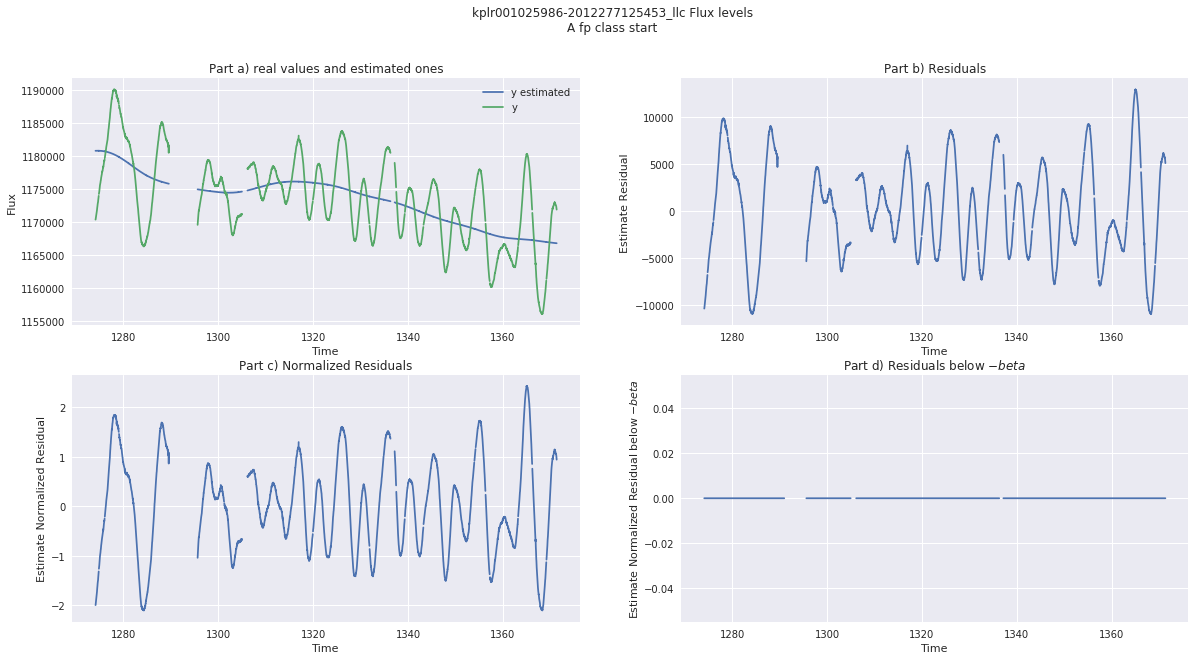

In [116]:
runCurve(rows[9])

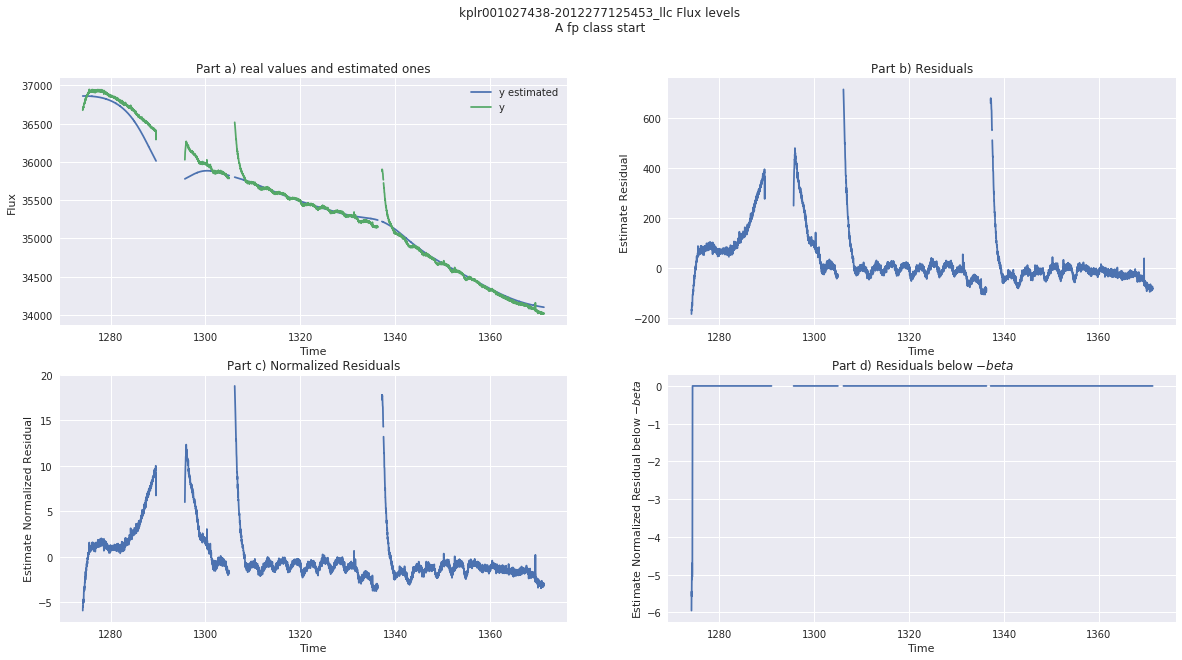

In [117]:
runCurve(rows[10])

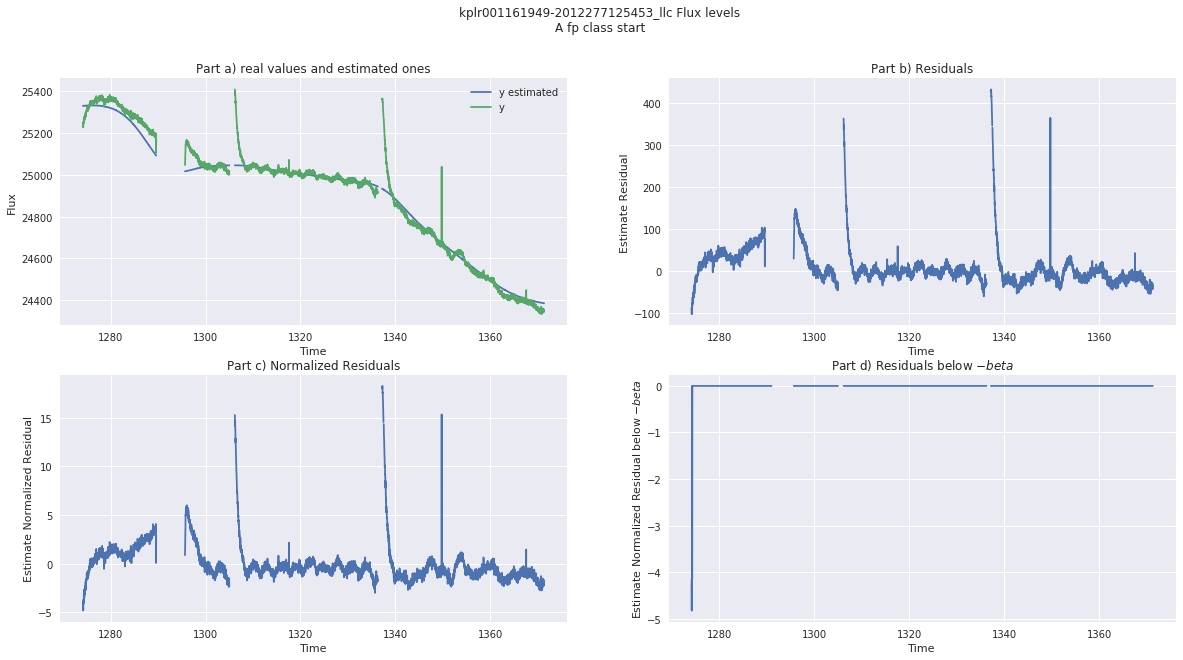

In [118]:
runCurve(rows[11])